<div align="center">
  <img src="https://github.com/Alek050/databallpy/assets/49450063/56100e87-c680-4dc1-82e5-4aa8fdbc8a34" alt="Logo">
</div>

# Preprocessing

## Introduction

Preprocessing is always an important step of data analysis. In the case of soccer data, this mainly relates to the tracking data. Here we will show what kind of different preprocessing steps are available in DataBallPy and how you can run them. Before we can showcase anything, we will load in a game object.

```python
from databallpy import get_game, get_open_game

game = get_game(
  tracking_data_loc="../data/tracking_data.dat",
  tracking_metadata_loc="../data/tracking_metadata.xml",
  tracking_data_provider="tracab"
  event_data_loc="../data/event_data_f24.xml",
  event_metadata_loc="../data/event_metadata_f7.xml",
  event_data_provider="opta",
)

# or get the open game provided by the DFL (Sportec Solutions)
game = get_open_game()
```

```{note}
Please see [Loading in a game](https://databallpy.readthedocs.io/en/latest/getting_started/loading_in_a_game_page.html) for extra information and the supported providers
```



In [1]:
import os
from databallpy import get_saved_game

game = get_saved_game(name="not_synced_game", path=os.path.join(os.getcwd(), "../saved_games"))
print(game.name)

T-30594695 2 - 2 T-c7f95633 1980-01-01 15:00:00


```{note}
The game object used in this example file contains 6 minutes of a game and is fully anonimised.
```

## Filtering Data

Soccer tracking data differs in quality, but in almost all cased filtering of coordinates is preferred. Tracking data is often captured by putting video footage of the game in deep learning models. Obstruction by other players can greatly influence the quality of the data. This is especially the case for the ball (the small ball is often obstructed) and in crowded situations (e.g. corner-kicks). For this situation we will apply a filter over the ball.

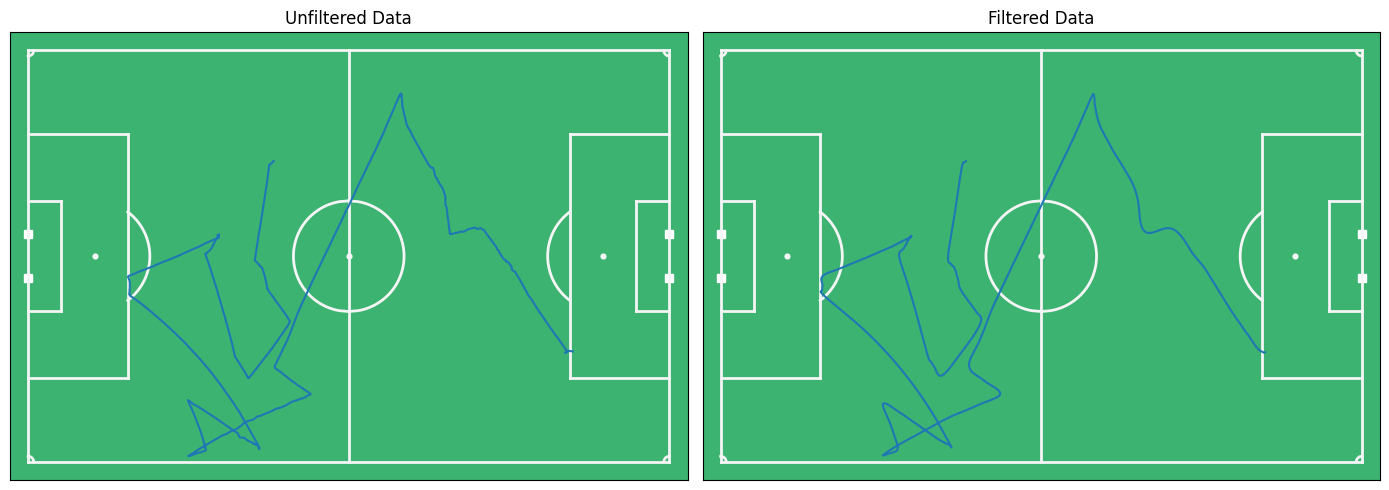

In [2]:
import matplotlib.pyplot as plt
from databallpy.visualize import plot_soccer_pitch
from databallpy.features.filters import filter_tracking_data

unfiltered_data = game.tracking_data
filtered_data = filter_tracking_data(game.tracking_data, column_ids="ball", filter_type="savitzky_golay", window_length=25, polyorder=2, inplace=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
fig, ax1 = plot_soccer_pitch(fig=fig, ax=ax1)
fig, ax2 = plot_soccer_pitch(fig=fig, ax=ax2)
ax1.plot(unfiltered_data.iloc[2000:3000]["ball_x"], unfiltered_data.iloc[2000:3000]["ball_y"], label="unfiltered")
ax2.plot(filtered_data.iloc[2000:3000]["ball_x"], filtered_data.iloc[2000:3000]["ball_y"], label="filtered")
ax1.set_title("Unfiltered Data")
ax2.set_title("Filtered Data")
fig.tight_layout()
plt.show()

```{note}
Filtering of data might not be necessary depending on your specific needs. The high number of frames chosen here is only to showcase how the filtering works, not an advice on how many frames you should filter your data on.
```

As you can see, the filtered data looks less noisy. Currently, two filter types are supported: "savitzkey_golay" and "moving_average". The window_length is the number of frames over which to filter, and should be adapted based on you specific data and sample rate. The polyorder argument is only used if "savitzkey_golay" is chosen as filter type.

The `filter_tracking_data` function is designed to apply filtering techniques to specific columns of a pandas DataFrame containing tracking data. This function supports two types of filters: the Savitzky-Golay filter and the moving average filter. It allows for in-place modification of the DataFrame or can return a new DataFrame with the filtered data.

### Parameters

- **tracking_data** (`pd.DataFrame`): The DataFrame containing the tracking data that needs filtering. This parameter is mandatory.

- **column_ids** (`str | list[str]`): Specifies the columns to which the filter should be applied. This can be a single column name as a string or a list of column names. 

- **filter_type** (`str`, optional): Determines the type of filter to apply. The options are `"savitzky_golay"` and `"moving_average"`. The default value is `"savitzky_golay"`.

- **window_length** (`int`, optional): Defines the length of the window used by the filter. This parameter is used by both filter types and defaults to `7`. For the Savitzky-Golay filter, this represents the number of coefficients (the polynomial order plus one). For the moving average, it specifies the number of points over which to average.

- **polyorder** (`int`, optional): Specifies the order of the polynomial used in the Savitzky-Golay filter. This parameter is ignored when using the moving average filter. The default value is `2`.

- **inplace** (`bool`, optional): If set to `True`, the filtering operation modifies the original DataFrame in place. If `False`, the function returns a new DataFrame with the filtered data, leaving the original DataFrame unchanged. The default value is `False`.

### Returns

- **pd.DataFrame**: If `inplace` is `False`, the function returns a new DataFrame with the specified columns filtered according to the selected filter type. If `inplace` is `True`, the function returns `None`, and the original DataFrame is modified in place.

```{note} Column ID
The column ID refers to a player or the ball. If you wish to refer to the ball, you can use the string "ball". If you wish to refer to a player, you can use the player's side (e.g., "home" or "away") and the player's jersey number (e.g., "home_10" or "away_7"). The function adds the suffix "_x" or "_y" to the column ID to filter the x and y coordinates, respectively. If you would like to get all the column IDs of a team, you can also call `game.home_players_column_ids()` or `game.away_players_column_ids()`.
```

## Adding Velocity and Acceleration

The next step in preprocessing is adding velocity and acceleration to the tracking data. This can be done by using the `add_velocity` and `add_acceleration` functions. The velocity is calculated by taking the difference between two consecutive frames and dividing it by the time difference. The acceleration is calculated by taking the difference between two consecutive velocities and dividing it by the time difference. The new columns are added to the tracking data dataframe.


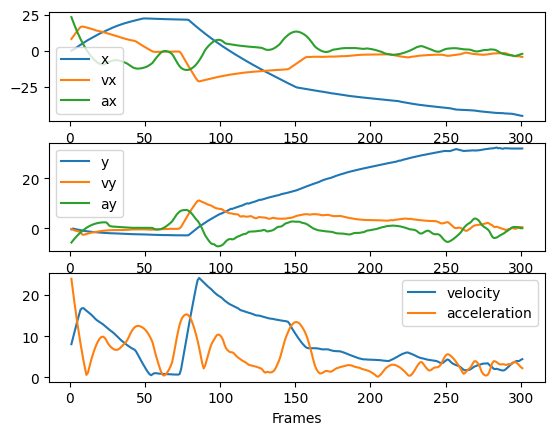

In [3]:
from databallpy.features.differentiate import add_velocity, add_acceleration

game.tracking_data = add_velocity(
    game.tracking_data, 
    frame_rate=game.frame_rate, 
    column_ids="ball", 
    max_velocity=50.,
    filter_type="moving_average",
    window_length=12,
    )
game.tracking_data = add_acceleration(
    game.tracking_data, 
    frame_rate=game.frame_rate, 
    column_ids="ball", 
    max_acceleration=20.,
    filter_type="savitzky_golay",
    window_length=35,
    polyorder=2
    )

fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

ax1.plot(game.tracking_data.loc[:300, "frame"], game.tracking_data.loc[:300,"ball_x"], label="x")
ax1.plot(game.tracking_data.loc[:300, "frame"], game.tracking_data.loc[:300, "ball_vx"], label="vx")
ax1.plot(game.tracking_data.loc[:300, "frame"], game.tracking_data.loc[:300,"ball_ax"], label="ax")
ax1.legend()

ax2.plot(game.tracking_data.loc[:300, "frame"], game.tracking_data.loc[:300,"ball_y"], label="y")
ax2.plot(game.tracking_data.loc[:300, "frame"], game.tracking_data.loc[:300,"ball_vy"], label="vy")
ax2.plot(game.tracking_data.loc[:300, "frame"], game.tracking_data.loc[:300,"ball_ay"], label="ay")
ax2.legend()

ax3.plot(game.tracking_data.loc[:300, "frame"], game.tracking_data.loc[:300,"ball_velocity"], label="velocity")
ax3.plot(game.tracking_data.loc[:300, "frame"], game.tracking_data.loc[:300,"ball_acceleration"], label="acceleration")
ax3.legend()
ax3.set_xlabel("Frames")

plt.show()


```{note}
The magnitude of the acceleration is calculated by taking the magnitude of the x and y acceleration, not by directly differentiating the velocity.
```

The `add_velocity` and `add_acceleration` functions are designed to calculate the velocity/acceleration of the players and the ball based on the tracking data. It adds new columns to the DataFrame containing the tracking data with the velocity values for each player and the ball. 

```{note}
The acceleration is calculated by differentiating the velocity, so before you can use the `add_acceleration` function, you need to have used the `add_velocity` function.
```

### Parameters

- **tracking_data** (`pd.DataFrame`): The DataFrame containing the tracking data to which the velocity/acceleration columns will be added. This parameter is mandatory.

- **column_ids** (`str | list[str]`): Specifies the columns for which the velocity/acceleration should be calculated. This can be a single column name as a string or a list of column names.

- **frame_rate** (`float`): The frame rate at which the tracking data was recorded. This parameter is mandatory and can be obtained from the game object (`game.frame_rate`).

- **filter_type** (`str`, optional): Determines the type of filter to apply to the velocity/acceleration data. The options are `"savitzky_golay"` and `"moving_average"`. The default value is `"savitzky_golay"`. Filtering is adviced during differentiating since it is known to amplify noise.

- **window_length** (`int`, optional): Defines the length of the window used by the filter. This parameter is used by both filter types and defaults to `7`. For the Savitzky-Golay filter, this represents the number of coefficients (the polynomial order plus one). For the moving average, it specifies the number of points over which to average.

- **polyorder** (`int`, optional): Specifies the order of the polynomial used in the Savitzky-Golay filter. This parameter is ignored when using the moving average filter. The default value is `2`.

- **max_velocity** or **max_acceleration** (`float`, optional): The maximum velocity/acceleration value that a player can achieve ($m/s$ or $m/s^{2}$). This parameter is used to clip the values to a maximum value. The default value is `np.inf`. 

````{margin}
```{warning}
If you wish to calculate the velocity/acceleration for both the players and the ball with different max values, you will have to run the function twice with different column_ids and max values.
```
````

- **inplace** (`bool`, optional): If set to `True`, the velocity/acceleration columns are added to the original DataFrame in place. If `False`, the function returns a new DataFrame with the additional columns, leaving the original DataFrame unchanged. The default value is `False`.

````{margin}
```{warning}
Using `inplace=True` can create a highly fragmented DataFrame. It is advised to use `inplace=False` and assign the result to a new variable.
```
````

### Returns

- **pd.DataFrame**: If `inplace` is `False`, the function returns a new DataFrame with the velocity/acceleration columns added. If `inplace` is `True`, the function returns `None`, and the original DataFrame is modified in place.

## Synchronizing Tracking and Event Data

This is a crucial step in preprocessing. A different page will be created to clearly explain the synchronisation process. For now, we will just show how you can synchronise your data:

```python
game.synchronise_tracking_and_event_data()
```

Ain't that easy?

## Team Possession

One of the important things to know in a game is which team has possession over the ball. Some data providers, like Tracab, already include this information in their tracking data, however, not all data providers do. In this case, you can use the event data to approximate which team has possession. For this you can use the `add_team_possession` function. This function will use the databallpy events to guess which team is in possession of the ball for every frame. This function will only work after you have synchronized the tracking and event data.




In [4]:
from databallpy import get_saved_game
import os

synced_game = get_saved_game(name="synced_game", path=os.path.join(os.getcwd(), "../saved_games"))
synced_game.tracking_data.rename(columns={"ball_possession": "ball_possession_original"}, inplace=True)

In [5]:
from databallpy.features.team_possession import add_team_possession

add_team_possession(synced_game.tracking_data, synced_game.event_data, synced_game.home_team_id, inplace=True)
synced_game.tracking_data.loc[synced_game.tracking_data["ball_status"] == "alive", ["ball_possession", "ball_possession_original"]].value_counts()
    

ball_possession  ball_possession_original
home             home                        3614
away             away                        1684
home             away                         320
away             home                         274
Name: count, dtype: int64

Okay agreed, it is not perfect. But it is a good start. The function will return a new column in the tracking data dataframe called "ball_possession". This column will contain the team that is in possession of the ball for every frame.

````{margin}
```{note}
If you have any questions or improvements, feel free to open an issue on the [GitHub page](https://github.com/Alek050/databallpy/issues/) of DataBallPy!
```
````

### Parameters

- **tracking_data** (`pd.DataFrame`): The DataFrame containing the tracking data to which the possession column will be added. This parameter is mandatory.

- **event_data** (`pd.DataFrame`): The DataFrame containing the event data. This parameter is mandatory.

- **home_team_id** (`int`): The ID of the home team. This parameter is mandatory and can be obtained from the game object (`game.home_team_id`).

- **inplace** (`bool`, optional): If set to `True`, the possession column is added to the original DataFrame in place. If `False`, the function returns a new DataFrame with the additional column, leaving the original DataFrame unchanged. The default value is `False`.

### Returns

- **pd.DataFrame**: If `inplace` is `False`, the function returns a new DataFrame with the possession column added. If `inplace` is `True`, the function returns `None`, and the original DataFrame is modified in place.

## Individual Player Possession

Similar to knowing which team has possession, it might also be necessary to know which individual player has possession for every given frame. The question becomes, when does a player has possession? This is a difficult question to answer, but currently we have implemented the propoces solution by a paper of Vidal-Codina et al (2022) : "Automatic Event Detection in Football Using Tracking Data". The algorithm finds if the ball is within the possession zone (PZ) of a player, it losses the ball when the ball is outside of the PZ in a next frame and a different player gains the ball in his PZ. The ball is only gained when the ball changes direction or speed, to correct for balls that fly over players. A dedicated page will be created to show the exact calculations. For now, you can use the `get_individual_player_possession` function to add a column to the tracking data dataframe with the player that has possession for every frame.

In [6]:
from databallpy.features import get_individual_player_possession

get_individual_player_possession(game.tracking_data, inplace=True)
print(game.tracking_data["player_possession"].value_counts().head())

player_possession
home_2     598
home_4     423
home_5     286
home_10    265
away_7     187
Name: count, dtype: int64


Seems like `"home_2"` had the ball in his poessession the longest. See the dedicated page of possession for more information about the player possession algorithm.

## Playing direction

As shown above, the basic playing direction in DataBallPy is team oriented, the home team is represented as playing from left to right the full game, while the away team is represented as playing from right to left. In some situations, you might be interested in different representations of the data. For instance, you might want to do an analysis on all pass locations on the pitch, independent of the team. To make this easier, we implemented a function to get the tracking data frame not oriented by whether the team is away or home, but by whether a team is ball possession or not. In that format, the playing direction of the team in possession is always from left to right. See the example below

In [7]:
import numpy as np

pass_start_locs_team = np.zeros((len(synced_game.pass_events), 3))
pass_start_locs_possession = np.zeros((len(synced_game.pass_events), 3))
for i, event in enumerate(synced_game.pass_events.values()):
    frame = synced_game.get_event_frame(event_id=event.event_id, playing_direction="team_oriented")
    pass_start_locs_team[i, :2] = frame[[f"ball_x", f"ball_y"]].values[0]
    pass_start_locs_team[i, 2] = int(event.team_side == "home")

    frame = synced_game.get_event_frame(event_id=event.event_id, playing_direction="possession_oriented")
    pass_start_locs_possession[i, :2] = frame[[f"ball_x", f"ball_y"]].values[0]
    pass_start_locs_possession[i, 2] = int(event.team_side == "home")

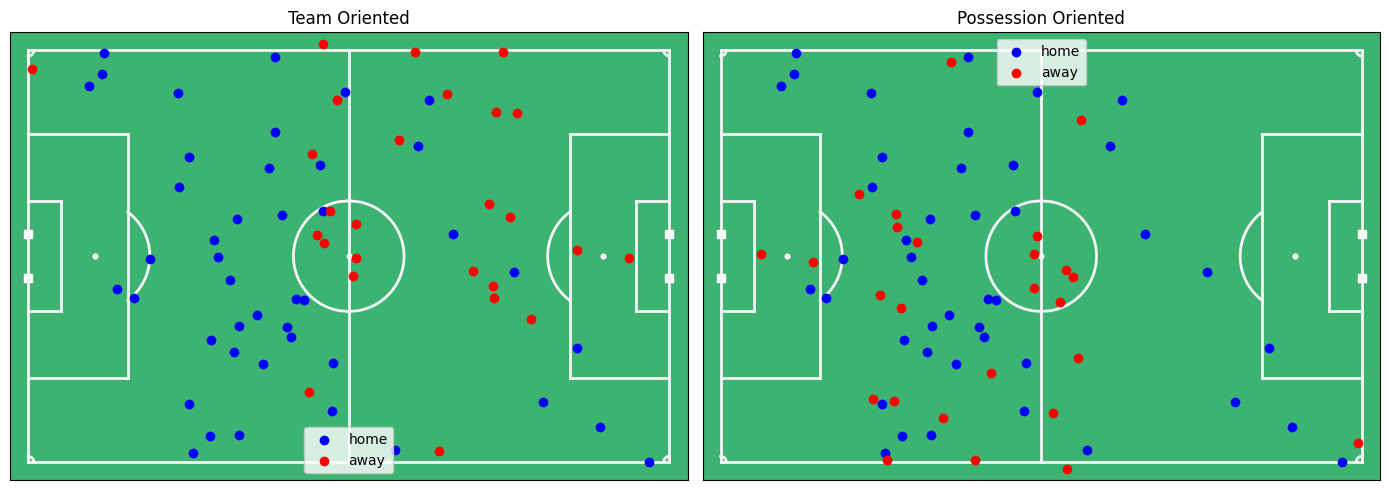

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
fig, ax1 = plot_soccer_pitch(fig=fig, ax=ax1)
fig, ax2 = plot_soccer_pitch(fig=fig, ax=ax2)

home_mask = pass_start_locs_team[:, 2] == 1
ax1.scatter(pass_start_locs_team[home_mask, 0], pass_start_locs_team[home_mask, 1], c="blue", label="home")
ax1.scatter(pass_start_locs_team[~home_mask, 0], pass_start_locs_team[~home_mask, 1], c="red", label="away")
ax2.scatter(pass_start_locs_possession[home_mask, 0], pass_start_locs_possession[home_mask, 1], c="blue", label="home")
ax2.scatter(pass_start_locs_possession[~home_mask, 0], pass_start_locs_possession[~home_mask, 1], c="red", label="away")
ax1.set_title("Team Oriented")
ax2.set_title("Possession Oriented")
ax1.legend()
ax2.legend()
fig.tight_layout()
plt.show()

As you can see, all the locations of the away team passes are now mirrored, meaning all events, and corresponding tracking data frame, are now oriented by the team that performs the event.

## Conclusion

This page showed the different preprocessing steps that are available in DataBallPy. The filtering of tracking data, adding velocity and acceleration, synchronizing tracking and event data, and calculating team and individual player possession are all important steps in the preprocessing of soccer data. These steps are crucial to ensure that the data is clean and ready for further analysis.

If you have any questions or improvements, feel free to open an issue on the [GitHub page](https://www.github.com/Alek050/databallpy/issues/) of DataBallPy!